In [81]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-

import time

import matplotlib.pyplot as plt
import numpy as np

from copy import copy, deepcopy


def round_up(num):
    """
    Returns the multiple of ten next to `num`.
    """
    if num % 10:
        return (10 - num % 10) + num
    else:
        return num

class Chromosome:
    """
    Implements basic structure for
    storing and operating on algorithm data.
    """
    def __init__(self, size=0, alphabet=[]):
        if not size:
            self.genes = np.ndarray(size)
        else:
            np.random.seed()
            self.genes = np.random.choice(alphabet, size)

        self.fitness = 0

    def __str__(self):
        return "".join(list(map(str, self.genes)))

    def calculate_fitness(self, target):
        """
        Calculates fitness of the individual
        given a target.
        """
        hits = 0
        for i, j in zip(self.genes, target):
            if i == j:
                hits += 1
        self.fitness = (hits * 100) / len(target)


class Population:
    """
    Implements basic operations on a set
    of Chromosome objects.
    """

    def __init__(self, alphabet, psize, csize):
        """
        :param alphabet: Symbols used to generate the chromosomes.
        :param psize: Population size.
        :param csize: Chromosome size.
        """
        self.alphabet = alphabet
        self.psize = psize
        self.csize = csize
        self.population = self._gen_pop(psize, csize, alphabet)

    def __str__(self):
        return "\n".join(map(str, self.population))

    def update(self, target):
        """
        Updates the fitness value for every
        individual in the population based on
        the given target.
        """
        for c in self.population:
            c.calculate_fitness(self.target)

    def get_fitness(self):
        """
        Returns the fitness value for every
        individual in the population.
        """
        return [c.fitness for c in self.population]

    def sort(self):
        """
        Sorts the elements of the population
        based on its fitness values.
        """
        self.population = sorted(self.population, key=lambda chromosome: chromosome.fitness)

    def renew(self):
        """
        Eliminates the half of the population
        with the worst fitness values, replacing
        them with a list of new randomly generated
        individuals.
        """
        index = int(len(self.population) / 2)
        self.population = self._gen_pop(index, self.csize, self.alphabet) \
                          + self.population[index:]

    def _gen_pop(self, psize, csize, alphabet):
        """
        Generates a new list of individuals randomly.

        :param psize: Size of the population to be generated.
        :param csize: Size of the Chromosome to be generated.
        :param alphabet: Set of symbols used to generate the population individuals.
        :return: A list of randomly generated individuals.
        """
        return [Chromosome(csize, alphabet) for _ in range(psize)]


class Randomwalk(Population):
    """
    Implements the steps of a Randomwalk
    algorithm based on the methods of the
    Population class.
    """
    def __init__(self, alphabet, target, psize, gcounter, tcounter=30):
        """

        :param alphabet: Symbols used to generate the population individuals.
        :param target: The target to be achieved by the algorithm.
        :param psize: Population size.
        :param gcounter: Max generations without change in best fitness permited.
        :param tcounter: Number of times the algorithm is executed.
        """
        self.alphabet = alphabet
        self.target = target
        self.csize = len(self.target)
        self.psize = psize
        self.gcounter = gcounter
        self.tcounter = tcounter

    def run(self, verbose=False):
        """
        Routine that combines the methods of the
        base class (Population) to perform the algorithm.

        :param verbose: If **True**, logs info during the execution of the algorithm.
        """

        # Initiate a list to receive the best fitness values
        # achieved per execution.
        self.best_scores = []

        # Initiate a list to receive the number of generations
        # spent per execution.
        self.generations = []

        if verbose:
            then = time.time()

            print("{!s} started...".format(type(self).__name__))
            print("Target: {!s}".format("".join(map(str, self.target))))
            print("Population size: {!s}".format(self.psize))
            print("Total executions: {!s}".format(self.tcounter))
            print("Max generations without change: {!s}\n".format(self.gcounter))

        # Runs the algorithm tcounter times.
        for i in range(self.tcounter):

            # Initiates the population and updates its fitness values
            # based on a given target.
            self.population = self._gen_pop(self.psize, self.csize, self.alphabet)
            self.update(self.target)

            # Initiates a list to receive the best fitness values
            # achieved per generation.
            scores = []

            j = 0  # Holds the value of the best fitness per generation.
            k = 1  # Holds the current generation.
            g = 0  # Holds the number of generations with no changes to the best fitness.

            if verbose:
                print("\nExecution {!s} started...\n".format(i + 1))

            while g < self.gcounter:

                self.sort()
                self.renew()
                self.update(self.target)
                self.sort()

                j = self.get_fitness()[-1]
                scores.append(j)

                # Only compares the last two elements of
                # score, if at least 2 generations had
                # been executed.
                if k >= 2:
                    if scores[-1] == scores[-2]:
                        g += 1
                    else:
                        g = 0

                if verbose:
                    print("\tGeneration {!s}".format(k))
                    print("\tBest individual: {!s}".format(self.population[-1]))
                    print("\tBest score: {!s}%\n".format(j))

                if verbose and j == 100:
                    print("\tTarget found!\n")
                    break

                k += 1

            self.best_scores.append(scores)
            self.generations.append(k - 1)

            if verbose:
                print("Execution {0!s} ended in {1!s} generations".format(i + 1, k - 1))
                print("Target: {!s}".format("".join(map(str, self.target))))
                print("Result: {!s}".format(self.population[-1]))
                print("Best score: {!s}%\n".format(scores[-1]))

        # Holds the number of the longest execution, rounded up to a multiple of ten.
        lexec = round_up(max([len(bscore) for bscore in self.best_scores]))

        # Normalizing the length of the scores lists,
        # repeating its last element until it fits lexec.
        for bscore in self.best_scores:
            bscore.extend([bscore[-1]] * (lexec - len(bscore)))

        # Calculating the mean and standard deviation
        # per generation.
        self.m = np.mean(self.best_scores, axis=0)
        self.std = np.std(self.best_scores, axis=0)

        # Creating a numpy array to be used index
        # by the plot method.
        self.idx = np.arange(1, lexec + 1)

        if verbose:
            now = time.time()

            # Sets a maximum of 4 decimal places for printing floats.
            np.set_printoptions(formatter={'float': '{: 0.4f}'.format})

            print("Mean score per generation:")
            print(self.m)
            print()
            print("Standard deviantion per generation:")
            print(self.std)
            print()
            print("Generations spent per execution:")
            print(self.generations)
            print()
            print("{!s} ended in {!s} seconds.".format(type(self).__name__, now - then))

    def plot(self):
        """
        Plots a graph displaying the mean values and the standard
        deviation per generation of the fitness values achieved.
        """

        plt.figure(figsize=(15, 10))
        plt.title(u"Média de Acertos por Geração")
        plt.xlabel(u"Gerações")
        plt.ylabel(u"Acertos (%)")
        plt.grid(alpha=0.3)
        plt.errorbar(self.idx, self.m, self.std, ls=None, color='r', ecolor='y', alpha=0.5)
        plt.show()


class GeneticAlgorithm(Population):
    """
    Implements the steps of a Genetic
    Algorithm based on the methods of
    the base class (Population) and on
    its own methods.
    """

    def __init__(self, alphabet, target, psize, rsize, mrate, brate, sigma, gcounter, tcounter=30):
        """

        :param alphabet: Set of symbols used to generate the individuals of the population.
        :param target: The target to be achieved by the algorithm.
        :param psize: Population size.
        :param rsize: Ring size.
        :param mrate: Mutation rate.
        :param brate: Breeding rate.
        :param sigma: Standard deviation used to propagate the mutation over an individual genes.
        :param gcounter: Max number of generations to run with no change to the best fitness per execution.
        :param tcounter: Number of times the algorithm is executed.
        """
        self.alphabet = alphabet
        self.target = target
        self.psize = psize
        self.rsize = rsize
        self.csize = len(self.target)
        self.mrate = mrate
        self.brate = brate
        self.sigma = sigma
        self.gcounter = gcounter
        self.tcounter = tcounter

    def select(self):
        selected = []
        threshold = 1 - self.rsize/self.psize

        for _ in range(self.psize):
            contenders = sorted(np.random.choice(self.population, self.rsize),
                                key=lambda chromosome: chromosome.fitness)
            if np.random.rand() < threshold:
                selected.append(contenders[-1])
            else:
                selected.append(contenders[0])
        return selected

    def breed(self, parents, points=2):
        children = []

        for i in range(0, self.psize -1, 2):
            couple = [parents[i], parents[i+1]]
            if np.random.rand() > self.brate:
                children.extend(couple)
            else:
                ch1, ch2 = couple[0], couple[1]

                pts = np.random.randint(0, self.csize, size=points)

                while pts[0]-pts[1] <= 1:
                    pts = np.random.randint(0, self.csize, size=2)

                ch1.genes[pts[1]:pts[0]], ch2.genes[pts[0]:pts[1]] = couple[1].genes[pts[1]:pts[0]], couple[0].genes[pts[0]:pts[1]]

                children.extend([ch1, ch2])

        return children

    def mutate(self):
        for chromosome in self.population:
            for i in range(1, self.csize - 1):
                if np.random.rand() < self.mrate:
                    chromosome.genes[i] = int(not(chromosome.genes[i]))

                    s = np.random.normal(0, self.sigma)
                    if not (s > -1.5*self.sigma and 1.5*self.sigma > s):
                        chromosome.genes[i-1] = int(not(chromosome.genes[i-1]))
                        chromosome.genes[i+1] = int(not(chromosome.genes[i+1]))
            # chromosome.calculate_fitness(self.target)

    #def __elitefy(self, elite):
    #    length = self.psize/2
    #    idx = np.random.randint(0, length)
    #    
    #    self.population[idx] = elite

    def run(self, verbose=False):
        """
        Routine that combines the methods of the
        base class (Population) to perform the algorithm.

        :param verbose: If **True**, logs info during the execution of the algorithm.
        """

        # Initiate a list to receive the best fitness values
        # achieved per execution.
        self.best_scores = []

        # Initiate a list to receive the number of generations
        # spent per execution.
        self.generations = []

        if verbose:
            then = time.time()

            print("{!s} started...".format(type(self).__name__))
            print("Target: {!s}".format("".join(map(str, self.target))))
            print("Population size: {!s}".format(self.psize))
            print("Total executions: {!s}".format(self.tcounter))
            print("Max generations without change: {!s}\n".format(self.gcounter))
            
        # Runs the algorithm tcounter times.
        for i in range(self.tcounter):

            # Initiates the population and updates its fitness values
            # based on a given target.
            self.population = self._gen_pop(self.psize, self.csize, self.alphabet)
            self.update(self.target)
            self.sort()

            # Initiates a list to receive the best fitness values
            # achieved per generation.
            scores = []

            #j = 0  # Holds the value of the best fitness per generation.
            k = 1  # Holds the current generation.
            g = 0  # Holds the number of generations with no changes to the best fitness.
            
            elite = Chromosome()
            elite.genes = self.population[-1].genes
            elite.fitness = self.population[-1].fitness

            if verbose:
                print('\nExecution {!s} started...\n'.format(i + 1))

            while g < self.gcounter:
                
                #print("Gen {!s}\n".format(k))
                #print("Elite ({!s}): {}".format(id(elite), elite.fitness))
                #print("Fitness:\n{}\n".format([c.fitness for c in self.population]))
                
                selected = self.select()
                self.population = self.breed(selected)
                self.mutate()
                self.update(self.target)
                self.sort()
                
                if self.population[-1].fitness > elite.fitness:
                    elite.genes = self.population[-1].genes
                    elite.fitness = self.population[-1].fitness
                    
                    if verbose:
                        print("\tNew elite ({!s}): {}".format(id(elite), elite.fitness))
                    #print("Fitness:\n{!s}\n".format([c.fitness for c in self.population]))
                    
                elif self.population[-1].fitness < elite.fitness:
                    length = self.psize/2
                    idx = np.random.randint(0, length)

                    self.population[idx].genes = elite.genes
                    self.population[idx].fitness = elite.fitness
                    
                    if verbose:
                        print("\tElite returned ({!s}): {}".format(id(elite), elite.fitness))
                    #print("Fitness before sorting:\n{}".format([c.fitness for c in self.population]))
                    self.sort()
                    #print("Fitness after sorting:\n{}\n".format([c.fitness for c in self.population]))
                    
                else: 
                    elite.genes = self.population[-1].genes
                    elite.fitness = self.population[-1].fitness
                    
                    if verbose:
                        print("\tElite ({!s} {}) not changed.".format(id(elite), elite.fitness))
                    #print("Fitness:\n{}\n".format([c.fitness for c in self.population]))
                
                scores.append(elite.fitness)

                # Only compares the last two elements of
                # score, if at least 2 generations had
                # been executed.
                if k >= 2:
                    if scores[-1] == scores[-2]:
                        g += 1
                    else:
                        g = 0

                if verbose:
                    print("\tGeneration {!s}".format(k))
                    print("\tBest individual: {!s}".format(self.population[-1]))
                    print("\tBest score: {!s}%\n".format(self.population[-1].fitness))

                if elite.fitness == 100:
                    print("\tTarget found!\n")
                    break

                k += 1

            self.best_scores.append(scores)
            self.generations.append(k - 1)

            if verbose:
                print("Execution {0!s} ended in {1!s} generations".format(i + 1, k - 1))
                print("Target: {}".format(self.target))
                print("Result: {}".format(self.population[-1]))
                print("Best score: {!s}%\n".format(scores[-1]))

        # Holds the number of the longest execution, rounded up to a multiple of ten.
        lexec = round_up(max([len(bscore) for bscore in self.best_scores]))

        # Normalizing the length of the scores lists,
        # repeating its last element until it fits lexec.
        for bscore in self.best_scores:
            bscore.extend([bscore[-1]] * (lexec - len(bscore)))

        # Calculates the mean and standard deviation
        # per generation.
        self.m = np.mean(self.best_scores, axis=0)
        self.std = np.std(self.best_scores, axis=0)

        # Creating a numpy array to be used index
        # by the plot method.
        self.idx = np.arange(1, lexec + 1)

        if verbose:
            now = time.time()

            # Sets a maximum of 4 decimal places for printing floats.
            np.set_printoptions(formatter={'float': '{: 0.4f}'.format})

            print("Mean score per generation:")
            print(self.m)
            print()
            print("Standard deviantion per generation:")
            print(self.std)
            print()
            print("Generations spent per execution:")
            print(self.generations)
            print()
            print("{!s} ended in {!s} seconds.".format(type(self).__name__, now - then))

    def plot(self):
        """
        Plots a graph displaying the mean values and the standard
        deviation per generation of the fitness values achieved.
        """

        plt.figure(figsize=(15, 10))
        plt.title(u"Média de Acertos por Geração")
        plt.xlabel(u"Gerações")
        plt.ylabel(u"Acertos (%)")
        plt.grid(alpha=0.3)
        plt.errorbar(self.idx, self.m, self.std, ls=None, color='b', ecolor='g', alpha=0.5)
        plt.show()


In [82]:
t1 = [1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1]
t2 = [1, 0, 1, 0, 0, 0, 0, 1, 1, 1]

psize1  =   20
psize2  =  100
psize3  =  500
psize4  = 1000
psize5  = 5000

gcount = 60

In [85]:
ag11 = GeneticAlgorithm(alphabet=[0, 1], target=t1, psize=psize4, rsize=3, mrate=0.03, brate=0.7, sigma=0.01, gcounter=gcount, tcounter=1)

In [86]:
ag11.run(verbose=True)

GeneticAlgorithm started...
Target: 1010000111000011010000111000011010000111
Population size: 1000
Total executions: 1
Max generations without change: 60


Execution 1 started...

	Elite returned (2715272098648): 77.5
	Generation 1
	Best individual: 1011101101000011010101101111010000100111
	Best score: 77.5%

	Elite (2715272098648 77.5) not changed.
	Generation 2
	Best individual: 1010000100001111010011110001010010000111
	Best score: 77.5%

	Elite returned (2715272098648): 77.5
	Generation 3
	Best individual: 1011011000100111010110101001001110101001
	Best score: 77.5%

	Elite (2715272098648 77.5) not changed.
	Generation 4
	Best individual: 1010001000000011010100010000011100000111
	Best score: 77.5%

	Elite returned (2715272098648): 77.5
	Generation 5
	Best individual: 1010011001101001011010011011011000100101
	Best score: 77.5%

	Elite returned (2715272098648): 77.5
	Generation 6
	Best individual: 0001001011110001101111011111000011010011
	Best score: 77.5%

	Elite returned (27152720986

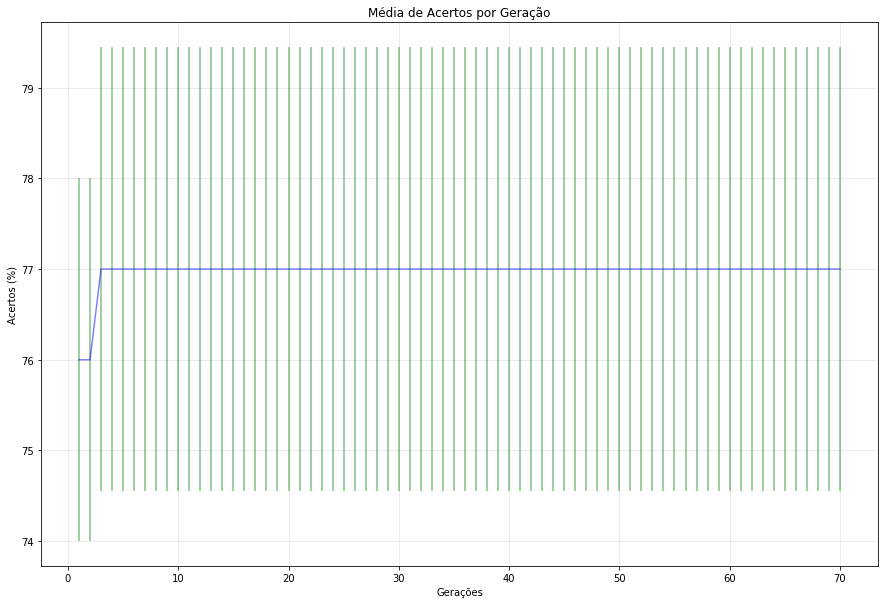

In [75]:
ag11.plot()

In [ ]:
rw11 = Randomwalk(alphabet=[0, 1], target=t1, psize=psize1, gcounter=gcount, tcounter=30)

In [34]:
a = [Chromosome() for _ in range(10)]

In [35]:
a

In [36]:
b = a[-1]


In [37]:
a[-1] = Chromosome()

In [39]:
a

In [40]:
b